In [1]:
import numpy as np
import networkx as nx
import networkx.generators.random_graphs as nxrg

In [2]:
def adjacency_gen(nnodes, undirected = False):
    adj = np.random.randint(2, size = (nnodes, nnodes), dtype = int)
    for i in range(nnodes):
        adj[i,i] = 0
    if(undirected):
        for i in range(nnodes):
            for j in range(i):
                adj[i,j] = adj[j,i]
    return adj

In [3]:
def flow_gen(adj, paths, nsample, Range=10, zero_centered=False, backflow = False, processed_paths = False, noise_level=0.2):
    '''
    generates flow samples based on eigenpaths with gaussian noise
    input:
    adj: adjacency matrix of graph, rows represent staring nodes, columns representing destination nodes
    paths: eigenpaths of a fixed length, 
        must be in the format [s1, d1, w1], [s2=d1, d2, w2], ... [sl=d(l-1), dl, wl]
        where s is the starting node of the edge, d is the ending node of the edge
        and w is the weight of each edge in the path
    nsample: number of samples generated
    backflow: allow edge adjacency matrix to have backflow, making it symetric
    noise: add gaussian noise or not
    
    output:
    sample: nsample * nedges np array
    edge_adj: edge adjacency matrix
    '''
    nEdges = 0
    #encode adjacency matrix into edge vector
    Edges = []
    for start in range(adj.shape[0]):
        for dest in range(adj.shape[0]):
            if(adj[start, dest] == 1):
                nEdges += 1
                Edges.append([start, dest])
    
    Paths = np.zeros((len(paths), nEdges), dtype = float)
    if processed_paths == False:
        for p in paths:
            prev_end = None
            for e in p:
                assert adj[e[0], e[1]] == 1 #all paths must exist
                assert prev_end is None or e[0] == prev_end #all paths must be valid
                prev_end = e[1]

        for p in range(len(paths)):
            for e in range(len(paths[0])):
                Paths[p, Edges.index(paths[p][e][0:2])] = paths[p][e][2]
    else:
        Paths = paths
    
    print("Edges:\n", Edges)
    print("Paths:\n", Paths)
    
    sample = np.zeros((nsample, nEdges), dtype = float)
    noiseless_sample = np.zeros((nsample, nEdges), dtype = float)
    for i in range(nsample):
        w = np.random.rand(len(paths))*Range #random weight for each path
        if zero_centered == True:
            w = w - Range/2
        sample[i,:] += w@Paths + Range * noise_level*np.random.randn(nEdges)
        noiseless_sample[i,:] += w@Paths
        
    #transform adjacency matrix into edge adjacecny matrix
    edge_adj = np.zeros((nEdges, nEdges), dtype = int)
    for e in range(nEdges):
        for i in range(adj.shape[0]):
            if(adj[Edges[e][1], i] == 1):
                edge_adj[e, Edges.index([Edges[e][1], i])] = 1
    
    if(backflow == True):
        for i in range(nEdges):
            for j in range(i):
                if(edge_adj[i.j] == 1 or edge_adj[j,i] == 1):
                    edge_adj[i,j] = 1 
                    edge_adj[j,i] = 1
    
    return sample, noiseless_sample, edge_adj, Paths

In [4]:
def path_gen(paths, weighted = False):
    results = []
    for pth in paths:
        print(pth)
        w_pth = []
        if weighted:
            weights = np.random.uniform(low = 5.0, high = 15.0, size = (len(pth)-1, ))
            for i in range(len(pth) - 1):
                w_pth.append([pth[i], pth[i+1], int(weights[i]) ])
        else:
            for i in range(len(pth) - 1):
                w_pth.append([pth[i], pth[i+1], 1 ])
            
        results.append(w_pth)
    return results

In [13]:
G = adjacency_gen(10, undirected = False)
print(G)

[[0 1 1 0 1 1 1 1 0 0]
 [0 0 0 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 1 0 0 1]
 [0 0 1 0 1 0 0 0 1 1]
 [1 1 0 0 1 1 0 0 1 1]
 [0 1 1 0 1 1 0 1 0 1]
 [0 1 0 0 0 1 0 0 0 0]]


In [52]:
gnp = nxrg.fast_gnp_random_graph(30, 0.3, seed=None, directed=False)
gnp_G = nx.adjacency_matrix(gnp).toarray()
print(gnp_G)

[[0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0]
 [1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0]
 [0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0]
 [1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1]
 [1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0]
 [1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1]
 [1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0

In [47]:
swg = nxrg.newman_watts_strogatz_graph(10, 4, 0.3)
swg_G = nx.adjacency_matrix(swg).toarray()
print(swg_G)

[[0 1 1 0 0 1 0 0 1 1]
 [1 0 1 1 1 0 0 0 0 1]
 [1 1 0 1 1 0 0 0 0 0]
 [0 1 1 0 1 1 0 1 0 0]
 [0 1 1 1 0 1 1 1 1 0]
 [1 0 0 1 1 0 1 1 1 0]
 [0 0 0 0 1 1 0 1 1 1]
 [0 0 0 1 1 1 1 0 1 1]
 [1 0 0 0 1 1 1 1 0 1]
 [1 1 0 0 0 0 1 1 1 0]]


In [8]:
sfg = nxrg.barabasi_albert_graph(100,2)
sfg_G = nx.adjacency_matrix(sfg).toarray()
print(sfg_G)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [6]:
G = np.load('graph.npy')
print(G)
loaded_paths = np.load('paths.npy')
print(loaded_paths)
restored_path = np.nonzero(loaded_paths)
print(restored_path)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]), array([  6,  32,  53,  61,  87,  22,  30,  52,  62, 116,  21, 152, 309,
       338, 387]))


[(27, 4), (31, 4), (33, 4), (36, 4), (38, 4), (41, 4), (43, 4), (46, 4), (50, 4), (51, 4), (53, 4), (56, 4), (59, 4), (61, 4), (62, 4), (63, 4), (64, 4), (65, 4), (66, 4), (67, 4), (69, 4), (70, 4), (71, 4), (73, 4), (75, 4), (77, 4), (78, 4), (79, 4), (80, 4), (81, 4), (82, 4), (83, 4), (84, 4), (85, 4), (86, 4), (87, 4), (88, 4), (89, 4), (90, 4), (91, 4), (92, 4), (93, 4), (94, 4), (95, 4), (96, 4), (97, 4), (98, 4), (99, 4), (15, 6), (23, 6), (24, 6), (25, 6), (30, 6), (34, 6), (35, 6), (37, 6), (39, 6), (40, 6), (44, 6), (48, 6), (49, 6), (52, 6), (54, 6), (55, 6), (57, 6), (60, 6), (68, 6), (72, 6), (74, 6), (76, 6), (0, 8), (14, 8), (16, 8), (19, 8), (26, 8), (29, 8), (32, 8), (42, 8), (47, 8), (58, 8), (8, 10), (13, 10), (22, 10), (28, 10), (17, 12), (45, 12), (21, 14), (10, 16), (12, 16), (18, 16), (4, 18), (20, 18), (6, 20), (2, 22), (11, 22), (9, 24), (1, 26), (7, 26), (5, 30), (3, 48)]


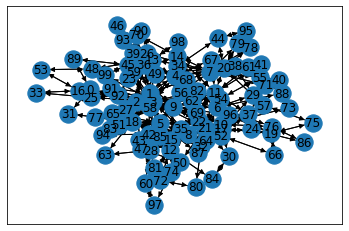

In [13]:
DiG = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
#DiG = G
nx.draw_networkx(DiG, with_label = True) 
degs = []
for node in range(100):
    deg = DiG.degree(node)
    degs.append((node, deg))
    
degs_sorted = sorted(degs, key=lambda deg: deg[1])

print(degs_sorted)

In [47]:
print(nx.diameter(DiG))
print(nx.shortest_path(DiG, 60, 7))

5
[60, 12, 69, 7]


In [7]:
swg_pth = path_gen([[8,7,1,2,4], 
                    [8,7,1,3,9]])
print(swg_pth)

[8, 7, 1, 2, 4]
[8, 7, 1, 3, 9]
[[[8, 7, 1], [7, 1, 1], [1, 2, 1], [2, 4, 1]], [[8, 7, 1], [7, 1, 1], [1, 3, 1], [3, 9, 1]]]


In [82]:
spaths = nx.all_simple_paths(sfg, 4, 3)
print(list(spaths))

[[4, 2, 0, 3], [4, 2, 0, 6, 3], [4, 2, 3], [4, 2, 5, 3], [4, 2, 7, 0, 3], [4, 2, 7, 0, 6, 3], [4, 2, 8, 3], [4, 2, 9, 3], [4, 3]]


In [48]:
sfg_pth = path_gen([[5, 1, 7, 4, 3, 9],                     
                    [10, 5,1,7, 4, 3,13,98],                     
                    [60,12, 69,7, 4, 3,99],
                    [80, 32, 18, 3, 13, 98]])
print(sfg_pth)

[5, 1, 7, 4, 3, 9]
[10, 5, 1, 7, 4, 3, 13, 98]
[60, 12, 69, 7, 4, 3, 99]
[80, 32, 18, 3, 13, 98]
[[[5, 1, 1], [1, 7, 1], [7, 4, 1], [4, 3, 1], [3, 9, 1]], [[10, 5, 1], [5, 1, 1], [1, 7, 1], [7, 4, 1], [4, 3, 1], [3, 13, 1], [13, 98, 1]], [[60, 12, 1], [12, 69, 1], [69, 7, 1], [7, 4, 1], [4, 3, 1], [3, 99, 1]], [[80, 32, 1], [32, 18, 1], [18, 3, 1], [3, 13, 1], [13, 98, 1]]]


In [66]:
npg_pth = path_gen([[12,0,11,8,20], 
                    [8,12,29,26,1],
                    [13,21,5,2,7]])
print(npg_pth)

[12, 0, 11, 8, 20]
[8, 12, 29, 26, 1]
[13, 21, 5, 2, 7]
[[[12, 0, 1], [0, 11, 1], [11, 8, 1], [8, 20, 1]], [[8, 12, 1], [12, 29, 1], [29, 26, 1], [26, 1, 1]], [[13, 21, 1], [21, 5, 1], [5, 2, 1], [2, 7, 1]]]


In [53]:
flows, noiseless_flows, edge_adj, paths = flow_gen(G, sfg_pth[0:3], 2000, Range=2, zero_centered=True, \
                                                   processed_paths = False, noise_level=0.2)

Edges:
 [[0, 2], [0, 3], [0, 31], [0, 89], [1, 2], [1, 5], [1, 7], [1, 8], [1, 23], [1, 25], [1, 34], [1, 36], [1, 39], [1, 42], [1, 65], [1, 68], [1, 91], [2, 0], [2, 1], [2, 3], [2, 4], [2, 6], [2, 15], [2, 16], [2, 26], [2, 47], [2, 48], [2, 94], [3, 0], [3, 2], [3, 4], [3, 5], [3, 9], [3, 11], [3, 13], [3, 16], [3, 17], [3, 18], [3, 25], [3, 27], [3, 28], [3, 34], [3, 35], [3, 45], [3, 51], [3, 52], [3, 54], [3, 62], [3, 77], [3, 82], [3, 91], [3, 99], [4, 2], [4, 3], [4, 6], [4, 7], [4, 23], [4, 36], [4, 38], [4, 39], [4, 67], [5, 1], [5, 3], [5, 8], [5, 9], [5, 10], [5, 12], [5, 18], [5, 22], [5, 47], [5, 51], [5, 56], [5, 58], [5, 65], [5, 83], [5, 87], [6, 2], [6, 4], [6, 19], [6, 29], [6, 58], [6, 62], [6, 64], [6, 76], [6, 82], [6, 88], [7, 1], [7, 4], [7, 13], [7, 14], [7, 26], [7, 40], [7, 55], [7, 56], [7, 61], [7, 69], [7, 71], [7, 78], [7, 79], [8, 1], [8, 5], [8, 17], [8, 24], [8, 81], [9, 3], [9, 5], [9, 10], [9, 11], [9, 12], [9, 20], [9, 22], [9, 27], [9, 43], [9, 45

In [71]:
print('noiseless:\n',noiseless_flows[0:1])
print('with noise:\n',flows[0:1])
noiseless_flows.shape

noiseless:
 [[ 0.          0.          0.         -0.23747479  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.99925106  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.99925106  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         -0.43117308  0.          0.
  -0.23747479  0.          0.          0.          0.          0

(2000, 310)

In [54]:
np.save('flows.npy', flows)
np.save('noiseless_flows.npy', noiseless_flows)
np.save('adj.npy', edge_adj)
np.save('paths.npy', paths)
np.save('graph.npy', G)

In [16]:
print(noiseless_flows[0])

[ 0.          0.          0.          0.          0.          0.
 48.98215367  0.          0.          0.          0.          0.
  0.          0.         48.98215367  0.          0.          0.
  0.          0.         48.98215367  0.          0.          0.
  0.          0.          0.         48.98215367  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
